In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import sys
import os
from dataclasses import dataclass
import json
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from llamawrapper import load_unemb_only, LlamaHelper
import seaborn as sns
from scipy.stats import bootstrap
from utils import plot_ci, plot_ci_plus_heatmap
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
# fix random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
sys.path.append('../tuned-lens')
from tuned_lens.nn.lenses import TunedLens,LogitLens

In [3]:
input_lang = 'fr'
target_lang = 'zh'
model_size = '13b'
out_dir = './visuals'
prefix = "./data/langs/"
df_en_fr = pd.read_csv(f'{prefix}{input_lang}/clean.csv').reindex()
df_en_de = pd.read_csv(f'{prefix}{target_lang}/clean.csv').reindex()

In [4]:
# Parameters
model_size = "13b"
target_lang = "en"
input_lang = "en"


In [5]:
llama = AutoModelForCausalLM.from_pretrained(  # type: ignore
                f"meta-llama/Llama-2-13b-hf",
                device_map={"": "cuda:0"},
                revision="main",
                torch_dtype="auto",
                local_files_only="true",cache_dir="/mnt/ssd-1/hf_cache/"
            )
llama_lens = TunedLens.from_model_and_pretrained(llama,f"meta-llama/Llama-2-13b-hf").to("cuda:0")
llama_logit_lens = LogitLens.from_model(llama).to("cuda:0")
tokenizer = AutoTokenizer.from_pretrained(
                f"meta-llama/Llama-2-7b-hf",local_files_only="true",cache_dir="/mnt/ssd-1/hf_cache/"
            )

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

params.pt AlignmentResearch/tuned-lens space main lens/meta-llama/Llama-2-13b-hf None


params.pt:   0%|          | 0.00/2.10G [00:00<?, ?B/s]

(…)ns/meta-llama/Llama-2-13b-hf/config.json:   0%|          | 0.00/259 [00:00<?, ?B/s]

In [6]:
unemb = nn.Sequential(llama.model.norm, llama.lm_head)
print(unemb)
# prepare for energy plots
U = list(unemb[1].parameters())[0].detach().cpu().float()
weights = list(unemb[0].parameters())[0].detach().cpu().float()
print(f'U {U.shape} weights {weights.unsqueeze(0).shape}')
U_weighted = U.clone() 
#U_weighted = U_weighted / ((U_weighted**2).mean(dim=1, keepdim=True))**0.5
U_weighted *= weights.unsqueeze(0)
U_normalized = U_weighted / ((U_weighted**2).sum(dim=1, keepdim=True))**0.5
v = U.shape[0]
TT = U_normalized.T @ U_normalized
avgUU = (((U_normalized.T @ U_normalized)**2).sum() / v**2)**0.5
print(avgUU.item())

Sequential(
  (0): LlamaRMSNorm()
  (1): Linear(in_features=5120, out_features=32000, bias=False)
)
U torch.Size([32000, 5120]) weights torch.Size([1, 5120])


0.11461826413869858


In [7]:
count = 0
for idx, word in enumerate(df_en_de['word_translation']):
    if word in tokenizer.get_vocab() or '▁'+word in tokenizer.get_vocab():
        count += 1

print(f'for {target_lang} {count} of {len(df_en_de)} are single tokens')

if input_lang == target_lang:
    df_en_de_fr = df_en_de.copy()
    df_en_de_fr.rename(columns={'word_original': 'en', 
                                f'word_translation': target_lang if target_lang != 'en' else 'en_tgt'}, 
                                inplace=True)
else:
    df_en_de_fr = df_en_de.merge(df_en_fr, on=['word_original'], suffixes=(f'_{target_lang}', f'_{input_lang}'))
    df_en_de_fr.rename(columns={'word_original': 'en', 
                                f'word_translation_{target_lang}': target_lang if target_lang != 'en' else 'en_tgt', 
                                f'word_translation_{input_lang}': input_lang if input_lang != 'en' else 'en_in'}, 
                                inplace=True)
# delete all rows where en is contained in de or fr
if target_lang != 'en':
    for i, row in df_en_de_fr.iterrows():
        if row['en'].lower() in row[target_lang].lower():
            df_en_de_fr.drop(i, inplace=True)

print(f'final length of df_en_de_fr: {len(df_en_de_fr)}')

for en 139 of 139 are single tokens
final length of df_en_de_fr: 139


In [8]:
def token_prefixes(token_str: str):
    n = len(token_str)
    tokens = [token_str[:i] for i in range(1, n+1)]
    return tokens 

def add_spaces(tokens):
    return ['▁' + t for t in tokens] + tokens

def capitalizations(tokens):
    return list(set(tokens))

def unicode_prefix_tokid(zh_char = "云", tokenizer=tokenizer):
    start = zh_char.encode().__str__()[2:-1].split('\\x')[1]
    unicode_format = '<0x%s>'
    start_key = unicode_format%start.upper()
    if start_key in tokenizer.get_vocab():
        return tokenizer.get_vocab()[start_key]
    return None

def process_tokens(token_str: str, tokenizer, lang):
    with_prefixes = token_prefixes(token_str)
    with_spaces = add_spaces(with_prefixes)
    with_capitalizations = capitalizations(with_spaces)
    final_tokens = []
    for tok in with_capitalizations:
        if tok in tokenizer.get_vocab():
            final_tokens.append(tokenizer.get_vocab()[tok])
    if lang in ['zh', 'ru']:
        tokid = unicode_prefix_tokid(token_str, tokenizer)
        if tokid is not None:
            final_tokens.append(tokid)
    return final_tokens

In [9]:

id2voc = {id:voc for voc, id in tokenizer.get_vocab().items()}
def get_tokens(token_ids, id2voc=id2voc):
    return [id2voc[tokid] for tokid in token_ids]

def compute_entropy(probas):
    return (-probas*torch.log2(probas)).sum(dim=-1)

lang2name = {'fr': 'Français', 'de': 'Deutsch', 'ru': 'Русский', 'en': 'English', 'zh': '中文'}
def sample(df, ind, k=5, tokenizer=tokenizer, lang1='fr', lang2='de', lang_latent='en'):
    df = df.reset_index(drop=True)
    temp = df[df.index!=ind]
    sample = pd.concat([temp.sample(k-1), df[df.index==ind]], axis=0)
    prompt = ""
    for idx, (df_idx, row) in enumerate(sample.iterrows()):
        if idx < k-1:
            prompt += f'{lang2name[lang1]}: "{row[lang1]}" - {lang2name[lang2]}: "{row[lang2]}"\n'
        else:
            prompt += f'{lang2name[lang1]}: "{row[lang1]}" - {lang2name[lang2]}: "'
            in_token_str = row[lang1]
            out_token_str = row[lang2]
            out_token_id = process_tokens(out_token_str, tokenizer, lang2)
            latent_token_str = row[lang_latent]
            latent_token_id = process_tokens(latent_token_str, tokenizer, 'en')
            intersection = set(out_token_id).intersection(set(latent_token_id))
            if len(out_token_id) == 0 or len(latent_token_id) == 0:
                yield None
            if lang2 != 'en' and len(intersection) > 0:
                yield None
            yield {'prompt': prompt, 
                'out_token_id': out_token_id, 
                'out_token_str': out_token_str,
                'latent_token_id': latent_token_id, 
                'latent_token_str': latent_token_str, 
                'in_token_str': in_token_str}

In [10]:
dataset = []
for ind in tqdm(range(len(df_en_de_fr))):
    d = next(sample(df_en_de_fr, ind, lang1=input_lang, lang2=target_lang))
    if d is None:
        continue
    dataset.append(d)

  0%|                                                                                                                                                                                                                 | 0/139 [00:00<?, ?it/s]

  1%|█▍                                                                                                                                                                                                       | 1/139 [00:00<00:24,  5.60it/s]

  1%|██▉                                                                                                                                                                                                      | 2/139 [00:00<00:28,  4.73it/s]

  2%|████▎                                                                                                                                                                                                    | 3/139 [00:00<00:24,  5.48it/s]

  3%|█████▊                                                                                                                                                                                                   | 4/139 [00:00<00:26,  5.17it/s]

  4%|███████▏                                                                                                                                                                                                 | 5/139 [00:00<00:24,  5.50it/s]

  4%|████████▋                                                                                                                                                                                                | 6/139 [00:01<00:29,  4.54it/s]

  5%|██████████                                                                                                                                                                                               | 7/139 [00:01<00:28,  4.62it/s]

  6%|███████████▌                                                                                                                                                                                             | 8/139 [00:01<00:28,  4.67it/s]

  6%|█████████████                                                                                                                                                                                            | 9/139 [00:01<00:28,  4.62it/s]

  7%|██████████████▍                                                                                                                                                                                         | 10/139 [00:02<00:25,  5.10it/s]

  8%|███████████████▊                                                                                                                                                                                        | 11/139 [00:02<00:25,  5.08it/s]

  9%|█████████████████▎                                                                                                                                                                                      | 12/139 [00:02<00:27,  4.68it/s]

  9%|██████████████████▋                                                                                                                                                                                     | 13/139 [00:02<00:24,  5.05it/s]

 10%|████████████████████▏                                                                                                                                                                                   | 14/139 [00:02<00:23,  5.21it/s]

 11%|█████████████████████▌                                                                                                                                                                                  | 15/139 [00:03<00:27,  4.48it/s]

 12%|███████████████████████                                                                                                                                                                                 | 16/139 [00:03<00:29,  4.23it/s]

 12%|████████████████████████▍                                                                                                                                                                               | 17/139 [00:03<00:26,  4.53it/s]

 13%|█████████████████████████▉                                                                                                                                                                              | 18/139 [00:03<00:25,  4.80it/s]

 14%|███████████████████████████▎                                                                                                                                                                            | 19/139 [00:03<00:24,  4.89it/s]

 14%|████████████████████████████▊                                                                                                                                                                           | 20/139 [00:04<00:24,  4.81it/s]

 15%|██████████████████████████████▏                                                                                                                                                                         | 21/139 [00:04<00:21,  5.37it/s]

 16%|███████████████████████████████▋                                                                                                                                                                        | 22/139 [00:04<00:21,  5.39it/s]

 17%|█████████████████████████████████                                                                                                                                                                       | 23/139 [00:04<00:21,  5.33it/s]

 17%|██████████████████████████████████▌                                                                                                                                                                     | 24/139 [00:04<00:23,  4.99it/s]

 18%|███████████████████████████████████▉                                                                                                                                                                    | 25/139 [00:05<00:20,  5.43it/s]

 19%|█████████████████████████████████████▍                                                                                                                                                                  | 26/139 [00:05<00:20,  5.47it/s]

 19%|██████████████████████████████████████▊                                                                                                                                                                 | 27/139 [00:05<00:20,  5.37it/s]

 20%|████████████████████████████████████████▎                                                                                                                                                               | 28/139 [00:05<00:20,  5.51it/s]

 21%|█████████████████████████████████████████▋                                                                                                                                                              | 29/139 [00:05<00:18,  5.90it/s]

 22%|███████████████████████████████████████████▏                                                                                                                                                            | 30/139 [00:05<00:18,  5.76it/s]

 22%|████████████████████████████████████████████▌                                                                                                                                                           | 31/139 [00:06<00:20,  5.18it/s]

 23%|██████████████████████████████████████████████                                                                                                                                                          | 32/139 [00:06<00:20,  5.17it/s]

 24%|███████████████████████████████████████████████▍                                                                                                                                                        | 33/139 [00:06<00:20,  5.07it/s]

 24%|████████████████████████████████████████████████▉                                                                                                                                                       | 34/139 [00:06<00:23,  4.42it/s]

 25%|██████████████████████████████████████████████████▎                                                                                                                                                     | 35/139 [00:07<00:22,  4.61it/s]

 26%|███████████████████████████████████████████████████▊                                                                                                                                                    | 36/139 [00:07<00:24,  4.25it/s]

 27%|█████████████████████████████████████████████████████▏                                                                                                                                                  | 37/139 [00:07<00:26,  3.91it/s]

 27%|██████████████████████████████████████████████████████▋                                                                                                                                                 | 38/139 [00:07<00:23,  4.21it/s]

 28%|████████████████████████████████████████████████████████                                                                                                                                                | 39/139 [00:07<00:21,  4.76it/s]

 29%|█████████████████████████████████████████████████████████▌                                                                                                                                              | 40/139 [00:08<00:20,  4.87it/s]

 29%|██████████████████████████████████████████████████████████▉                                                                                                                                             | 41/139 [00:08<00:18,  5.33it/s]

 30%|████████████████████████████████████████████████████████████▍                                                                                                                                           | 42/139 [00:08<00:19,  4.89it/s]

 31%|█████████████████████████████████████████████████████████████▊                                                                                                                                          | 43/139 [00:08<00:17,  5.45it/s]

 32%|███████████████████████████████████████████████████████████████▎                                                                                                                                        | 44/139 [00:08<00:17,  5.37it/s]

 32%|████████████████████████████████████████████████████████████████▋                                                                                                                                       | 45/139 [00:09<00:17,  5.49it/s]

 33%|██████████████████████████████████████████████████████████████████▏                                                                                                                                     | 46/139 [00:09<00:16,  5.61it/s]

 34%|███████████████████████████████████████████████████████████████████▋                                                                                                                                    | 47/139 [00:09<00:15,  5.81it/s]

 35%|█████████████████████████████████████████████████████████████████████                                                                                                                                   | 48/139 [00:09<00:16,  5.37it/s]

 35%|██████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 49/139 [00:09<00:17,  5.12it/s]

 36%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                | 50/139 [00:09<00:17,  5.13it/s]

 37%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                              | 51/139 [00:10<00:15,  5.52it/s]

 37%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 52/139 [00:10<00:14,  5.85it/s]

 38%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 53/139 [00:10<00:15,  5.40it/s]

 39%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 54/139 [00:10<00:15,  5.43it/s]

 40%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 55/139 [00:10<00:15,  5.56it/s]

 40%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 56/139 [00:11<00:14,  5.90it/s]

 41%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 57/139 [00:11<00:14,  5.77it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 58/139 [00:11<00:14,  5.54it/s]

 42%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 59/139 [00:11<00:14,  5.64it/s]

 43%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 60/139 [00:11<00:13,  5.96it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 61/139 [00:11<00:13,  5.91it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 62/139 [00:12<00:13,  5.61it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 63/139 [00:12<00:14,  5.12it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 64/139 [00:12<00:16,  4.59it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 65/139 [00:12<00:15,  4.72it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 66/139 [00:12<00:13,  5.41it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 67/139 [00:13<00:13,  5.22it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 68/139 [00:13<00:13,  5.29it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 69/139 [00:13<00:14,  4.78it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 70/139 [00:13<00:14,  4.80it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 71/139 [00:13<00:13,  4.90it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 72/139 [00:14<00:13,  5.15it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 73/139 [00:14<00:12,  5.33it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 74/139 [00:14<00:12,  5.07it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 75/139 [00:14<00:14,  4.50it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 76/139 [00:14<00:13,  4.59it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 77/139 [00:15<00:14,  4.23it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 78/139 [00:15<00:13,  4.47it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 79/139 [00:15<00:14,  4.16it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 80/139 [00:16<00:15,  3.86it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 81/139 [00:16<00:16,  3.62it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 82/139 [00:16<00:15,  3.60it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 83/139 [00:16<00:15,  3.73it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 84/139 [00:17<00:14,  3.84it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 85/139 [00:17<00:13,  3.98it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 86/139 [00:17<00:12,  4.26it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 87/139 [00:17<00:11,  4.41it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 88/139 [00:18<00:11,  4.32it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 89/139 [00:18<00:13,  3.69it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 90/139 [00:18<00:11,  4.34it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 91/139 [00:18<00:11,  4.21it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 92/139 [00:18<00:10,  4.46it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 93/139 [00:19<00:10,  4.35it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 94/139 [00:19<00:09,  4.63it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 95/139 [00:19<00:09,  4.40it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 96/139 [00:19<00:09,  4.46it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 97/139 [00:20<00:09,  4.35it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 98/139 [00:20<00:09,  4.41it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 99/139 [00:20<00:10,  3.98it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 100/139 [00:20<00:09,  4.13it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 101/139 [00:20<00:08,  4.67it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 102/139 [00:21<00:08,  4.42it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 103/139 [00:21<00:09,  4.00it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 104/139 [00:21<00:08,  3.95it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 105/139 [00:22<00:08,  3.99it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 106/139 [00:22<00:09,  3.51it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 107/139 [00:22<00:08,  3.82it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 108/139 [00:22<00:08,  3.83it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 109/139 [00:23<00:07,  4.01it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 110/139 [00:23<00:06,  4.29it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 111/139 [00:23<00:07,  3.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 112/139 [00:23<00:06,  4.06it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 113/139 [00:24<00:06,  4.08it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 114/139 [00:24<00:06,  4.03it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 115/139 [00:24<00:06,  3.89it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 116/139 [00:24<00:05,  3.95it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 117/139 [00:25<00:05,  4.38it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 118/139 [00:25<00:04,  4.30it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 119/139 [00:25<00:04,  4.67it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 120/139 [00:25<00:04,  4.48it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 121/139 [00:25<00:04,  4.43it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 122/139 [00:26<00:03,  4.47it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 123/139 [00:26<00:03,  4.73it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 124/139 [00:26<00:02,  5.02it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 125/139 [00:26<00:02,  5.13it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 126/139 [00:26<00:02,  5.14it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 127/139 [00:27<00:02,  4.40it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 128/139 [00:27<00:02,  3.89it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 129/139 [00:27<00:02,  3.83it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 130/139 [00:28<00:02,  3.70it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 131/139 [00:28<00:02,  3.57it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 132/139 [00:28<00:01,  3.72it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 133/139 [00:28<00:01,  3.77it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 134/139 [00:29<00:01,  4.15it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 135/139 [00:29<00:00,  4.47it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 136/139 [00:29<00:00,  4.73it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 137/139 [00:29<00:00,  4.77it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 138/139 [00:29<00:00,  4.71it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:30<00:00,  4.51it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:30<00:00,  4.62it/s]

In [11]:
df = pd.DataFrame(dataset)
os.makedirs(f'{out_dir}/translation', exist_ok=True)
df.to_csv(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_dataset.csv', index=False)

In [12]:
df

,prompt,out_token_id,out_token_str,latent_token_id,latent_token_str,in_token_str
0,"English: ""example"" - English: ""example""\nEngli...","[2909, 3143, 29890, 289, 833, 1045]",book,"[2909, 3143, 29890, 289, 833, 1045]",book,book
1,"English: ""dance"" - English: ""dance""\nEnglish: ...","[274, 29883, 17184, 695, 23642, 9570, 15126, 1...",cloud,"[274, 29883, 17184, 695, 23642, 9570, 15126, 1...",cloud,cloud
2,"English: ""sound"" - English: ""sound""\nEnglish: ...","[2291, 19548, 23156, 29890, 289, 9922]",bag,"[2291, 19548, 23156, 29890, 289, 9922]",bag,bag
3,"English: ""song"" - English: ""song""\nEnglish: ""t...","[13394, 29442, 286, 4346, 21026, 2730, 29885]",mouth,"[13394, 29442, 286, 4346, 21026, 2730, 29885]",mouth,mouth
4,"English: ""office"" - English: ""office""\nEnglish...","[577, 29879, 578, 22473, 269]",soil,"[577, 29879, 578, 22473, 269]",soil,soil
...,...,...,...,...,...,...
134,"English: ""line"" - English: ""line""\nEnglish: ""l...","[374, 5161, 10107, 364, 3780, 14451, 29878]",rise,"[374, 5161, 10107, 364, 3780, 14451, 29878]",rise,rise
135,"English: ""square"" - English: ""square""\nEnglish...","[29880, 25874, 280, 2175, 1563, 454, 301]",left,"[29880, 25874, 280, 2175, 1563, 454, 301]",left,left
136,"English: ""sea"" - English: ""sea""\nEnglish: ""lin...","[6047, 3669, 577, 29879, 29802, 578, 269]",sound,"[6047, 3669, 577, 29879, 29802, 578, 269]",sound,sound
137,"English: ""pond"" - English: ""pond""\nEnglish: ""s...","[3081, 29886, 4764, 282, 1129, 12248, 13519, 772]",power,"[3081, 29886, 4764, 282, 1129, 12248, 13519, 772]",power,power


In [13]:
def get_logits(model, prompt,lens):
    inputs = tokenizer(prompt, return_tensors="pt").to('cuda')
    output = llama(inputs.input_ids, output_hidden_states=True)
    hidden_states = output.hidden_states[:-1]
    final_lps = output.logits.log_softmax(dim=-1)
    final_probs = final_lps.exp()
    tensors=[]
    for i in range(32):
        h = hidden_states[i].squeeze(0)
        tensors+=[lens(h, idx=i).detach().cpu()]
    tensors= torch.stack(tensors)  
    hidden_states = torch.stack(hidden_states).squeeze(1).detach().cpu()
    return tensors,hidden_states
        

In [14]:
in_token_probs = []
latent_token_probs = []
out_token_probs = []
entropy = []
energy = []
latents_all = []

for idx, d in tqdm(enumerate(dataset)):
    logits,latents = get_logits(llama, d['prompt'],llama_lens)
    last = logits[:, -1, :].float().softmax(dim=-1).detach().cpu()
    latent_token_probs += [last[:, torch.tensor(d['latent_token_id'])].sum(dim=-1)]
    out_token_probs += [last[:, torch.tensor(d['out_token_id'])].sum(dim=-1)]
    entropy += [compute_entropy(last)]
    latents_all += [latents[:, -1, :].float().detach().cpu().clone()]
    latents_normalized = latents[:, -1, :].float()
    latents_normalized = latents_normalized / (((latents_normalized**2).mean(dim=-1, keepdim=True))**0.5)
    latents_normalized /= (latents_normalized.norm(dim=-1, keepdim=True))
    norm = ((U_normalized @ latents_normalized.T)**2).mean(dim=0)**0.5
    energy += [norm/avgUU]

latent_token_probs = torch.stack(latent_token_probs)
out_token_probs = torch.stack(out_token_probs)
entropy = torch.stack(entropy)
energy = torch.stack(energy)
latents = torch.stack(latents_all)

0it [00:00, ?it/s]

1it [00:00,  1.22it/s]

2it [00:01,  2.18it/s]

3it [00:01,  2.76it/s]

4it [00:01,  3.23it/s]

5it [00:01,  3.65it/s]

6it [00:01,  4.01it/s]

7it [00:02,  4.15it/s]

8it [00:02,  4.39it/s]

9it [00:02,  4.53it/s]

10it [00:02,  4.64it/s]

11it [00:02,  4.47it/s]

12it [00:03,  4.61it/s]

13it [00:03,  4.50it/s]

14it [00:03,  4.39it/s]

15it [00:03,  4.23it/s]

16it [00:04,  4.18it/s]

17it [00:04,  4.39it/s]

18it [00:04,  4.55it/s]

19it [00:04,  4.42it/s]

20it [00:05,  4.16it/s]

21it [00:05,  4.25it/s]

22it [00:05,  4.39it/s]

23it [00:05,  4.47it/s]

24it [00:05,  4.50it/s]

25it [00:06,  4.40it/s]

26it [00:06,  4.36it/s]

27it [00:06,  4.42it/s]

28it [00:06,  4.57it/s]

29it [00:07,  4.59it/s]

30it [00:07,  4.52it/s]

31it [00:07,  4.45it/s]

32it [00:07,  4.67it/s]

33it [00:07,  4.76it/s]

34it [00:08,  4.87it/s]

35it [00:08,  4.69it/s]

36it [00:08,  4.52it/s]

37it [00:08,  4.60it/s]

38it [00:08,  4.76it/s]

39it [00:09,  4.64it/s]

40it [00:09,  4.66it/s]

41it [00:09,  4.80it/s]

42it [00:09,  4.94it/s]

43it [00:09,  5.00it/s]

44it [00:10,  5.02it/s]

45it [00:10,  5.09it/s]

46it [00:10,  5.09it/s]

47it [00:10,  5.12it/s]

48it [00:10,  5.11it/s]

49it [00:11,  5.11it/s]

50it [00:11,  4.95it/s]

51it [00:11,  5.03it/s]

52it [00:11,  5.05it/s]

53it [00:11,  5.08it/s]

54it [00:12,  5.13it/s]

55it [00:12,  5.16it/s]

56it [00:12,  5.17it/s]

57it [00:12,  5.11it/s]

58it [00:12,  5.12it/s]

59it [00:13,  5.09it/s]

60it [00:13,  5.11it/s]

61it [00:13,  5.04it/s]

62it [00:13,  4.95it/s]

63it [00:13,  4.97it/s]

64it [00:14,  4.99it/s]

65it [00:14,  5.01it/s]

66it [00:14,  4.81it/s]

67it [00:14,  4.91it/s]

68it [00:14,  4.97it/s]

69it [00:15,  5.01it/s]

70it [00:15,  5.00it/s]

71it [00:15,  4.98it/s]

72it [00:15,  5.09it/s]

73it [00:15,  5.16it/s]

74it [00:16,  5.11it/s]

75it [00:16,  5.05it/s]

76it [00:16,  5.06it/s]

77it [00:16,  5.11it/s]

78it [00:16,  4.94it/s]

79it [00:17,  4.84it/s]

80it [00:17,  4.82it/s]

81it [00:17,  4.90it/s]

82it [00:17,  4.91it/s]

83it [00:17,  4.91it/s]

84it [00:18,  4.93it/s]

85it [00:18,  4.94it/s]

86it [00:18,  4.93it/s]

87it [00:18,  4.84it/s]

88it [00:19,  4.78it/s]

89it [00:19,  4.82it/s]

90it [00:19,  4.88it/s]

91it [00:19,  4.86it/s]

92it [00:19,  4.89it/s]

93it [00:20,  4.90it/s]

94it [00:20,  4.93it/s]

95it [00:20,  4.95it/s]

96it [00:20,  4.75it/s]

97it [00:20,  4.92it/s]

98it [00:21,  5.01it/s]

99it [00:21,  4.93it/s]

100it [00:21,  4.88it/s]

101it [00:21,  4.91it/s]

102it [00:21,  5.02it/s]

103it [00:22,  5.09it/s]

104it [00:22,  5.20it/s]

105it [00:22,  5.31it/s]

106it [00:22,  5.43it/s]

107it [00:22,  5.32it/s]

108it [00:22,  5.10it/s]

109it [00:23,  5.19it/s]

110it [00:23,  5.29it/s]

111it [00:23,  5.35it/s]

112it [00:23,  5.37it/s]

113it [00:23,  5.44it/s]

114it [00:24,  5.29it/s]

115it [00:24,  5.40it/s]

116it [00:24,  5.40it/s]

117it [00:24,  5.43it/s]

118it [00:24,  5.46it/s]

119it [00:24,  5.48it/s]

120it [00:25,  5.33it/s]

121it [00:25,  5.32it/s]

122it [00:25,  5.18it/s]

123it [00:25,  5.10it/s]

124it [00:25,  5.26it/s]

125it [00:26,  5.32it/s]

126it [00:26,  5.26it/s]

127it [00:26,  5.35it/s]

128it [00:26,  5.34it/s]

129it [00:26,  5.45it/s]

130it [00:27,  5.11it/s]

131it [00:27,  5.23it/s]

132it [00:27,  5.11it/s]

133it [00:27,  5.22it/s]

134it [00:27,  5.05it/s]

135it [00:28,  4.89it/s]

136it [00:28,  4.88it/s]

137it [00:28,  4.96it/s]

138it [00:28,  4.76it/s]

139it [00:28,  4.77it/s]

139it [00:28,  4.80it/s]

In [15]:
print(latents.shape)

torch.Size([139, 40, 5120])


/mnt/ssd-1/gpaulo/llm-latent-language/utils.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


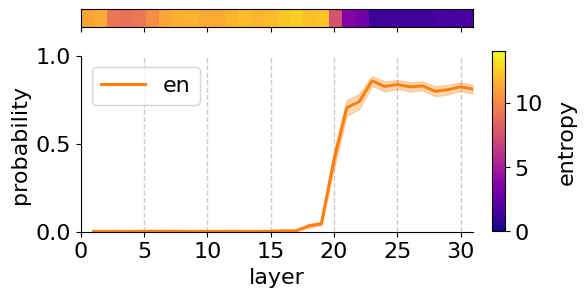

In [16]:
size2tik = {'7b': 5, '13b': 5, '70b': 10}
fig, ax, ax2 = plot_ci_plus_heatmap(latent_token_probs, entropy, 'en', color='tab:orange', tik_step=size2tik[model_size], do_colorbar=True, #, do_colorbar=(model_size=='70b'),
nums=[.99, 0.18, 0.025, 0.6])
if target_lang != 'en':
    plot_ci(ax2, out_token_probs, target_lang, color='tab:blue', do_lines=False)
ax2.set_xlabel('layer')
ax2.set_ylabel('probability')
if model_size == '7b':
    ax2.set_xlim(0, out_token_probs.shape[1]+1)
else:
    ax2.set_xlim(0, round(out_token_probs.shape[1]/10)*10+1)
ax2.set_ylim(0, 1)
# make xticks start from 1
# put legend on the top left
ax2.legend(loc='upper left')
os.makedirs(f'{out_dir}/translation', exist_ok=True)

plt.savefig(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_probas_ent.pdf', dpi=300, bbox_inches='tight')

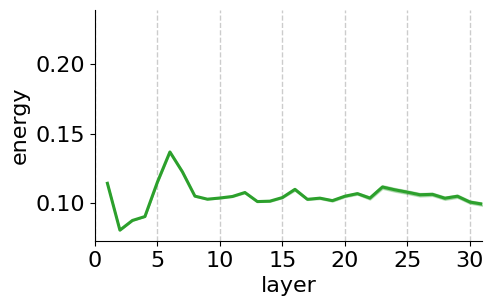

In [17]:
size2tik = {'7b': 5, '13b': 5, '70b': 10}

fig, ax2 = plt.subplots(figsize=(5,3))
plot_ci(ax2, energy, 'energy', color='tab:green', do_lines=True, tik_step=size2tik[model_size])
ax2.set_xlabel('layer')
ax2.set_ylabel('energy')
if model_size == '7b':
    ax2.set_xlim(0, out_token_probs.shape[1]+1)
else:
    ax2.set_xlim(0, round(out_token_probs.shape[1]/10)*10+1)
os.makedirs(f'{out_dir}/translation', exist_ok=True)
plt.savefig(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_energy.pdf', dpi=300, bbox_inches='tight')